Imports and google drive mount:

In [47]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import string
import time

from collections import Counter
from keras.models import model_from_json 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Download test dataset

In [48]:
zip_path = '/content/drive/My Drive/KNN/HDR_dataset.zip'
!cp "{zip_path}" .
!unzip -q 'HDR_dataset.zip'

replace crop_h1/I00009.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace crop_h1/I00008.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


read test dataset

In [0]:
hdr_dataset_images = []
hdr_dataset_labels = []

with open('trainVal.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            # Skip header row
            line_count += 1
        else:
            if(len(row[2]) != 7):
                continue
            img = cv2.imread(row[1])
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            normalizedImg = np.zeros((200, 40))
            normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
            res = cv2.resize(normalizedImg, dsize=(200, 40), interpolation=cv2.INTER_CUBIC)
            hdr_dataset_labels.append([row[2]])
            hdr_dataset_images.append(res)

hdr_dataset_images = np.asarray(hdr_dataset_images)
hdr_dataset_labels = np.asarray(hdr_dataset_labels)

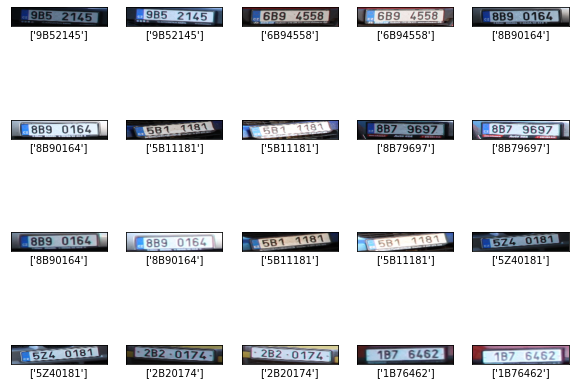

In [50]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(hdr_dataset_images[i], cmap=plt.cm.binary)
    plt.xlabel(hdr_dataset_labels[i])
plt.show()


Evaluate accuracy of model on test dataset, calculate and print statistics

In [0]:
# decode to license plate characters
map_numbers_to_char = {}
for i,d in enumerate(string.digits+string.ascii_uppercase):
    map_numbers_to_char[i] = d

# transform nn output into list with license plate characters
def get_readable_prediction(nn_output):
    idxs = [np.argmax(x) for x in nn_output]
    lp = [map_numbers_to_char[idx] for idx in idxs]
    return lp


# comapre two lists, count statistics 
def is_prediction_right(lstPrediction, lstLabel, statistics):
    lstPrediction = np.array(lstPrediction)
    lstLabel = np.array(lstLabel)
    if (lstPrediction==lstLabel).all():
        statistics['total_chars'] += len(lstPrediction)
        return True
    else:

        # # debug
        # print("pred :",lstPrediction)
        # print("label:",lstLabel)
        # print()
        for j, char in enumerate(lstLabel):
            if char != lstPrediction[j]:
                statistics['branch_list'][j].append(char)
                statistics['chars_count'] += 1
            statistics['total_chars'] += 1
        return False


def test_weights(loaded_model):
    total = len(hdr_dataset_images)
    same_as_label = 0
    branch_list = [[] for _ in range(7)]
    statistics = {'chars_count': 0, 'total_chars': 0, 'branch_list':branch_list}

    # # debug
    # print (statistics)
    # print(list(hdr_dataset_labels[0][0]))
    # print(get_readable_prediction(prediction_1_lp))

    time_measurements = {'start':0,'end':0}
    for i, image in enumerate(hdr_dataset_images):
        start = time.clock()  
        lp_prediction = loaded_model.predict(np.asarray([image]))
        end = time.clock()
        time_measurements['start'] += start
        time_measurements['end'] += end
        readable_prediction = get_readable_prediction(lp_prediction)
        if is_prediction_right(
            readable_prediction, 
            list(hdr_dataset_labels[i][0]),
            statistics
            ): 
            same_as_label += 1

    print("successfuly recognized: ", same_as_label)
    print("total: ", total)
    success_rate = same_as_label/total*100
    print("successful rate: {}%".format(str(round(success_rate, 2))))

    print("error rate [%] (character/license plate): {}/{}".format(
        str(round(
            statistics['chars_count']/statistics['total_chars']*100,
            2
            )),
         str(round((100 - success_rate), 2)),
    ))
    time_per_image = ((time_measurements['end'] - time_measurements['start'])
                      /len(hdr_dataset_images))
    print("Time per image: {} ".format( str(round(time_per_image, 10)))) 

    letter_stats = [Counter(x )for x in statistics['branch_list']]
    print (letter_stats)
    return success_rate


# print(statistics)

Load every model and weights and print all of them and the best one at the end

In [0]:
path_to_model = '/content/drive/My Drive/KNN/whole-small-model.json'
best_weights = []
for i in range(1,81):
    if i < 10:
        path_to_weights = '/content/drive/My Drive/KNN/model_small/model-small-{}.hdf5'.format('0' + str(i))
    else:
        path_to_weights = '/content/drive/My Drive/KNN/model_small/model-small-{}.hdf5'.format(i)
    # load json and create model
    json_file = open(path_to_model, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path_to_weights)
    print('-------------model {}------------------'.format(i))
    best_weights.append(test_weights(loaded_model))
idx = best_weights.index(max(best_weights))
idx += 1  # numbering from 1 not from zero
print('index of best model:', idx)

if idx < 10:
    path_to_weights = '/content/drive/My Drive/KNN/model_small/model-small-{}.hdf5'.format('0' + str(idx))
else:
    path_to_weights = '/content/drive/My Drive/KNN/model_small/model-small-{}.hdf5'.format(idx)

json_file = open(path_to_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path_to_weights)
print("-------------model {}------------------".format(idx))
_ = test_weights(loaded_model)

In [0]:
# get hardware info
from psutil import *
print(cpu_count())
!cat /proc/cpuinfo | grep 'model name'
!nvidia-smi -L
!nvidia-smi

In [55]:
import operator
from collections import Counter, defaultdict

# todo change counter
c = [Counter({'8': 9, '9': 6, '2': 6, '7': 6, '1': 5, 'B': 4, '5': 4, '6': 4, '3': 3, '4': 2, 'L': 2, 'F': 2, 'D': 2, 'S': 2, 'Z': 1}), Counter({'B': 16, 'Z': 11, 'M': 7, 'T': 5, 'A': 3, 'H': 2, 'I': 2, 'N': 1, '0': 1, 'S': 1, 'J': 1, 'E': 1}), Counter({'1': 9, '0': 8, '6': 6, '7': 6, 'D': 4, 'I': 4, '4': 4, 'J': 4, 'Z': 3, '5': 3, 'E': 2, 'T': 2, '3': 2, '9': 2, 'N': 2, 'H': 1, 'P': 1, 'A': 1, 'X': 1, 'C': 1, '8': 1, 'B': 1}), Counter({'7': 9, '6': 6, '8': 5, '1': 4, '3': 4, '5': 3, '2': 3, '4': 3, '0': 2, '9': 1}), Counter({'8': 11, '3': 11, '9': 8, '2': 7, '4': 7, '1': 6, '6': 6, '7': 6, '0': 2}), Counter({'3': 14, '7': 8, '2': 6, '5': 6, '1': 5, '4': 5, '8': 4, '9': 4, '6': 4, '0': 4, 'B': 3, 'J': 2}), Counter({'4': 14, '5': 14, '8': 11, '3': 10, '7': 8, '9': 7, '6': 5, '1': 4, '0': 4, '2': 4, 'G': 2, 'C': 1})]

for i, x in enumerate(c):
    freqword = defaultdict(list)
    for word, freq in x.items():
        freqword[freq].append(word)

    # print in order of occurrence (with sorted list of words)

    wrong_char_in_column = 0
    for freq in sorted(freqword,reverse=True):
        print('col: {}- mistakes: {}: char: {}'.format(i+1, freq, sorted(freqword[freq])))
        wrong_char_in_column += freq
    print("column {} mistakes {}".format(i+1,wrong_char_in_column))

freqword = {}
for i, x in enumerate(c):
    for word, freq in x.items():
        freqword[word] = 0

for i, x in enumerate(c):
    for word, freq in x.items():
        freqword[word] += freq

    # print in order of occurrence (with sorted list of words)
sorted_x = sorted(freqword.items(), key=operator.itemgetter(1))
print("mistakes_together", sorted_x)

y_map = [x for x in(string.digits+string.ascii_uppercase)]
print(y_map)

lst = []
for x in sorted_x:
    for a in x:
        lst.append(a)
        break

print(lst)
print("zero mistakes: ",list(set(y_map) - set(lst)))


col: 1- mistakes: 9: char: ['8']
col: 1- mistakes: 6: char: ['2', '7', '9']
col: 1- mistakes: 5: char: ['1']
col: 1- mistakes: 4: char: ['5', '6', 'B']
col: 1- mistakes: 3: char: ['3']
col: 1- mistakes: 2: char: ['4', 'D', 'F', 'L', 'S']
col: 1- mistakes: 1: char: ['Z']
column 1 mistakes 30
col: 2- mistakes: 16: char: ['B']
col: 2- mistakes: 11: char: ['Z']
col: 2- mistakes: 7: char: ['M']
col: 2- mistakes: 5: char: ['T']
col: 2- mistakes: 3: char: ['A']
col: 2- mistakes: 2: char: ['H', 'I']
col: 2- mistakes: 1: char: ['0', 'E', 'J', 'N', 'S']
column 2 mistakes 45
col: 3- mistakes: 9: char: ['1']
col: 3- mistakes: 8: char: ['0']
col: 3- mistakes: 6: char: ['6', '7']
col: 3- mistakes: 4: char: ['4', 'D', 'I', 'J']
col: 3- mistakes: 3: char: ['5', 'Z']
col: 3- mistakes: 2: char: ['3', '9', 'E', 'N', 'T']
col: 3- mistakes: 1: char: ['8', 'A', 'B', 'C', 'H', 'P', 'X']
column 3 mistakes 33
col: 4- mistakes: 9: char: ['7']
col: 4- mistakes: 6: char: ['6']
col: 4- mistakes: 5: char: ['8']
col